# MS malware Prediction

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt


import lightgbm as lgb
import xgboost as xgb

import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import gc

## 转换数据类型，减少内存占用

In [2]:
loader = pd.read_csv(r'D:\Desktop\MS ML Intern\MS Malware Pridiction\MSWeek3 - 4\train.csv',chunksize=5)
type(loader)

#=-----------------------------
sample_chunk = None
for chunk in loader:
    sample_chunk = chunk
    break
sample_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 83 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MachineIdentifier                                  5 non-null      object 
 1   ProductName                                        5 non-null      object 
 2   EngineVersion                                      5 non-null      object 
 3   AppVersion                                         5 non-null      object 
 4   AvSigVersion                                       5 non-null      object 
 5   IsBeta                                             5 non-null      int64  
 6   RtpStateBitfield                                   5 non-null      int64  
 7   IsSxsPassiveMode                                   5 non-null      int64  
 8   DefaultBrowsersIdentifier                          0 non-null      float64
 9   AVProductState

In [4]:
columns = list(sample_chunk.columns)
print('Number of columns:{}'.format(len(columns)))

Number of columns:83


### 优化方法:
1. 将对象（字符串）列转换为分类（category）类型
2. 将二进制（binary）值转换为int8类型
3. 将包含二进制值和缺失值的列转换为float16类型
4. 将64位编码转换为32位或16位

### 定义工具函数
*  根据train set里的列值范围，决定downscale的数据类型

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    start_mem = df.memory_usage().sum() / 1024**2   
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics: #downscale numerics & Object--->Category
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
                    
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
        
    return df

In [10]:
#_______________________load train dataset_______________________________________
# retained_columns = numerical_columns + categorical_columns
%time train = pd.read_csv(r'D:\Desktop\MS ML Intern\MS Malware Pridiction\MSWeek3 - 4\train.csv')

<timed exec>:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 51.6 s
Wall time: 7min 4s


In [11]:
%time train = reduce_mem_usage(train)

Mem. usage decreased to 3028.92 Mb (46.4% reduction)
CPU times: total: 2.62 s
Wall time: 14.3 s


In [17]:
# 获取所有Object类型的列
%time object_columns = train.select_dtypes(include=['object']).columns
# 将这些列的数据类型转换为Category
%time train[object_columns] = train[object_columns].astype('category')

CPU times: total: 1.11 s
Wall time: 1.79 s
CPU times: total: 18.7 s
Wall time: 33.1 s


In [19]:
train.memory_usage().sum() / 1024**2

1619.691261291504

In [20]:
Static_train = train

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 83 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   MachineIdentifier                                  category
 1   ProductName                                        category
 2   EngineVersion                                      category
 3   AppVersion                                         category
 4   AvSigVersion                                       category
 5   IsBeta                                             int8    
 6   RtpStateBitfield                                   float16 
 7   IsSxsPassiveMode                                   int8    
 8   DefaultBrowsersIdentifier                          float16 
 9   AVProductStatesIdentifier                          float32 
 10  AVProductsInstalled                                float16 
 11  AVProductsEnabled                    

In [22]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


# Exploratory Data Analysis

In [23]:
detect_no = (train["HasDetections"]==0).sum()
detect_yes = (train["HasDetections"]==1).sum()

print(detect_no,detect_yes)

4462591 4458892


### 统计:取值个数，缺失率，第一类占比,数据类型

In [24]:
stats = []

for col in train.columns:
    stats.append((col, 
                  train[col].nunique(), 
                  train[col].isnull().sum() * 100 / train.shape[0], 
                  train[col].value_counts(normalize=True, dropna=False).values[0] * 100, 
                  train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 
                                        'Unique_values', 
                                        'Percentage of missing values', 
                                        'Percentage of values in the biggest category', 
                                        'type'])

stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
28,PuaMode,2,99.974119,99.974119,category
41,Census_ProcessorClass,3,99.589407,99.589407,category
8,DefaultBrowsersIdentifier,1730,95.141637,95.141637,float16
68,Census_IsFlightingInternal,2,83.044030,83.044030,float16
52,Census_InternalBatteryType,78,71.046809,71.046809,category
...,...,...,...,...,...
1,ProductName,6,0.000000,98.935569,category
45,Census_HasOpticalDiskDrive,2,0.000000,92.281272,int8
54,Census_OSVersion,469,0.000000,15.845202,category
55,Census_OSArchitecture,3,0.000000,90.858045,category


1. 部分特征的缺失比率非常高，显然对于预测没有帮助，应该被删除
2. 有相当一部分的特征其中95%的值相等，相比于0/1label五五开而言，其数据极其不平衡，所以我认为这列也是无效的
3. 存在一两个特征具有非常多的取值，意味着这个特征并不是分类变量，应该属于纯数值类可以丢掉

In [25]:
filtered_features = stats_df[(stats_df['Percentage of missing values'] < 50) & (stats_df['Percentage of values in the biggest category'] < 90)]
dropped_features = stats_df[(stats_df['Percentage of missing values'] > 50) | (stats_df['Percentage of values in the biggest category'] > 90)]
selected_features = filtered_features['Feature'].tolist()
dropped_features = dropped_features['Feature'].tolist()
print(len(dropped_features))
print(len(selected_features))

30
53


*Now we have new train dataset*

In [26]:
stats_df = stats_df[stats_df['Feature'].isin(selected_features)]
stats_df = stats_df.sort_values(by='Percentage of missing values', ascending=False)
stats_df

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
31,SmartScreen,21,35.610795,48.379658,category
15,OrganizationIdentifier,49,30.841487,47.037662,float16
14,CityIdentifier,107366,3.647477,3.647477,float32
81,Wdft_RegionIdentifier,15,3.401352,20.177195,float16
80,Wdft_IsGamer,2,3.401352,69.205344,float16
53,Census_InternalBatteryNumberOfCharges,41087,3.012448,56.643094,float32
72,Census_FirmwareManufacturerIdentifier,712,2.054109,30.253692,float16
73,Census_FirmwareVersionIdentifier,50494,1.794915,1.794915,float32
37,Census_OEMModelIdentifier,175365,1.145919,3.416271,float32
36,Census_OEMNameIdentifier,2564,1.070203,14.428946,float16


In [45]:
retrain = train[selected_features]
retrain.shape

(8921483, 53)

In [46]:
retrain.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,...,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,...,UNKNOWN,IS_GENUINE,Retail,628.0,36144.0,0,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,...,UNKNOWN,OFFLINE,Retail,628.0,57858.0,0,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,...,FullAuto,IS_GENUINE,OEM:NONSLP,142.0,52682.0,0,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,...,FullAuto,IS_GENUINE,OEM:NONSLP,355.0,20050.0,0,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,...,FullAuto,IS_GENUINE,Retail,355.0,19844.0,0,0,0.0,1.0,1


In [29]:
label = ['HasDetections']

特殊处理少部分缺失值较多的特征列(不用特殊处理Binary feature):
1. SmartScreen
2. OrganizationIdentifier

In [47]:
# retrain.SmartScreen.value_counts()

#将缺失值NULL处理为str:NoExist
retrans_dict = {
    'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On', 'requireadmin': 'RequireAdmin', 'OFF': 'Off', 
    'Promt': 'Prompt', 'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
    '00000000': '0', '&#x03;': '3', np.nan: 'NoExist'
}

%time retrain.replace({'SmartScreen': retrans_dict}, inplace=True)

#retrain.SmartScreen.value_counts()

CPU times: total: 31.2 ms
Wall time: 63.8 ms


<timed eval>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
# retrain.OrganizationIdentifier.value_counts()
%time retrain.replace({'OrganizationIdentifier': {np.nan: 0}}, inplace=True)

CPU times: total: 46.9 ms
Wall time: 70.4 ms


<timed eval>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
retrain.dropna(inplace=True)
retrain.shape

C:\Users\26034\AppData\Local\Temp\ipykernel_23972\2223322948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrain.dropna(inplace=True)


(5073302, 53)

Drop MachineIdentifier 对于预测并没有帮助

In [50]:
retrain.drop('MachineIdentifier', axis=1, inplace=True)

C:\Users\26034\AppData\Local\Temp\ipykernel_23972\3750064296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrain.drop('MachineIdentifier', axis=1, inplace=True)


### Label Encoding for category columns

In [51]:
retrain['SmartScreen'] = retrain.SmartScreen.astype('category')

cate_cols = retrain.select_dtypes(include = 'category').columns.tolist()

from sklearn.preprocessing import LabelEncoder

# 创建 LabelEncoder 对象
le = LabelEncoder()

for col in cate_cols:
    retrain[col] = le.fit_transform(retrain[col])

C:\Users\26034\AppData\Local\Temp\ipykernel_23972\1024351211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrain['SmartScreen'] = retrain.SmartScreen.astype('category')
C:\Users\26034\AppData\Local\Temp\ipykernel_23972\1024351211.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrain[col] = le.fit_transform(retrain[col])
C:\Users\26034\AppData\Local\Temp\ipykernel_23972\1024351211.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [3]:
def reduce_mem_usage1(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


#%time retrain = reduce_mem_usage1(retrain)
# retrain.info()

In [43]:
retrain.memory_usage().sum() / 1024**2

527.3722820281982

In [44]:
retrain.shape

(5073302, 52)

### 相关性分析
* 尝试按批次分析特征相关性，剔除可能存在的高度共线性特征和 相关性非常小的特征

In [52]:
cols = retrain.columns.tolist()
print(len(cols))

52


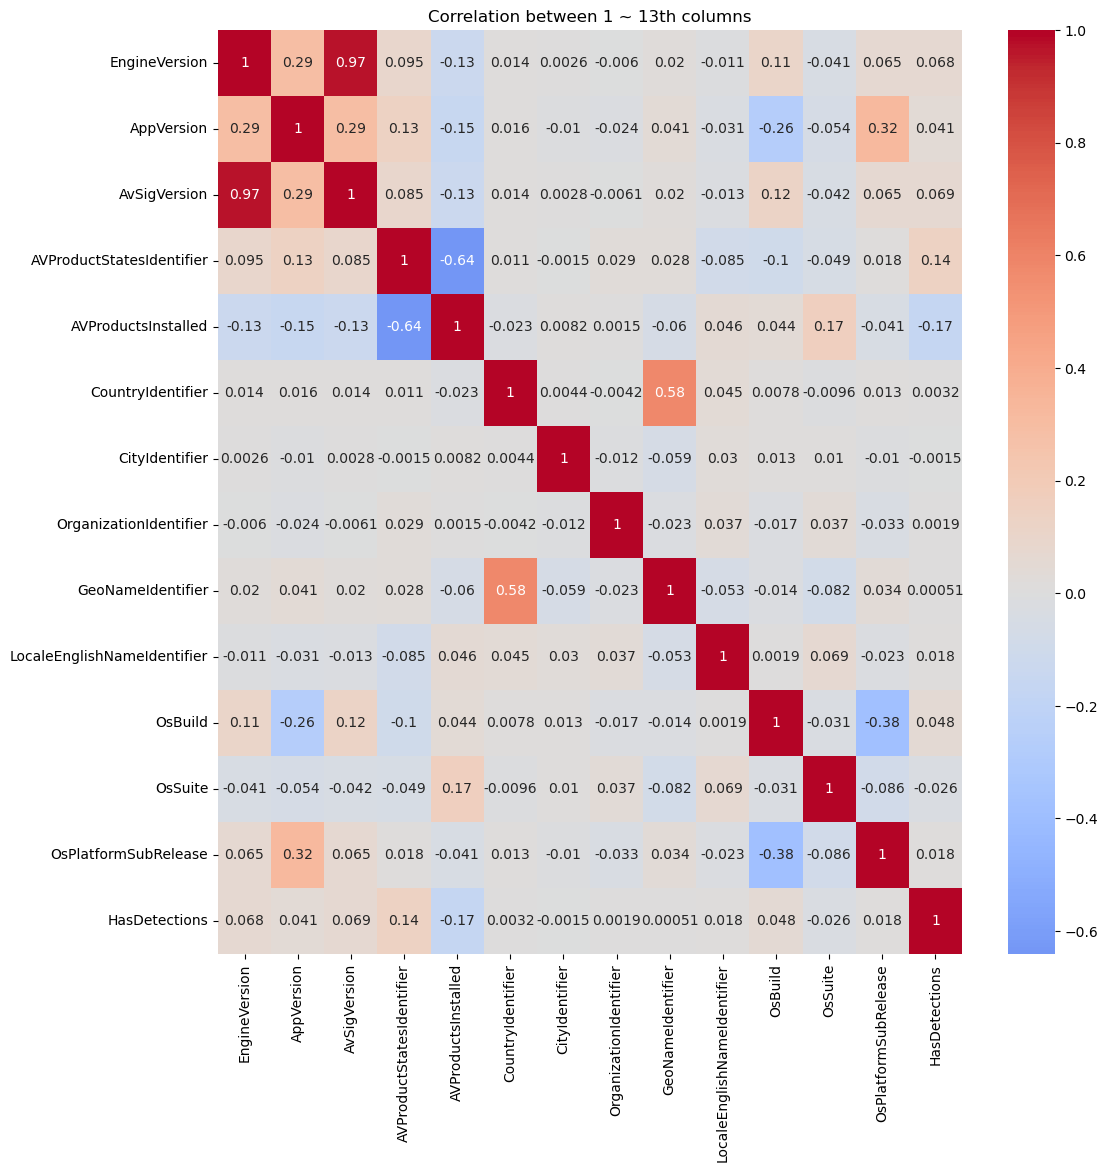

In [53]:
plt.figure(figsize=(12,12))

group_cols = cols[:13]
group_cols.append('HasDetections')

sns.heatmap(retrain[group_cols].corr(), cmap='coolwarm', annot=True, center=0.0)

plt.title('Correlation between 1 ~ 13th columns')
plt.show()

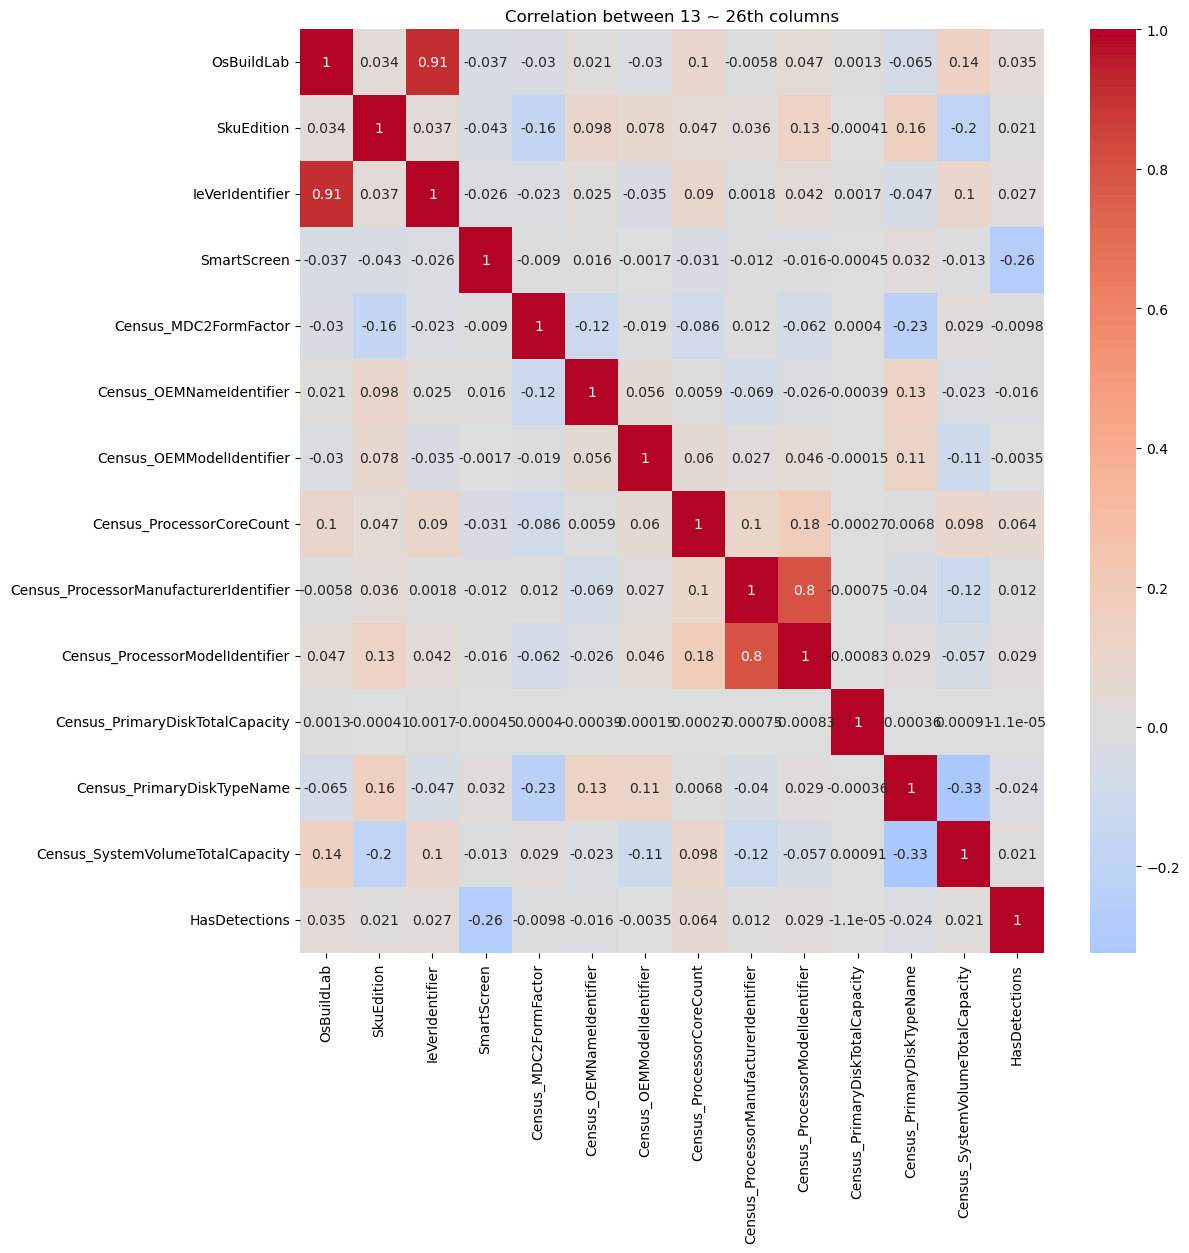

In [54]:
plt.figure(figsize=(12,12))

group_cols = cols[13:26]
group_cols.append('HasDetections')

sns.heatmap(retrain[group_cols].corr(), cmap='coolwarm', annot=True, center=0.0)

plt.title('Correlation between 13 ~ 26th columns')
plt.show()

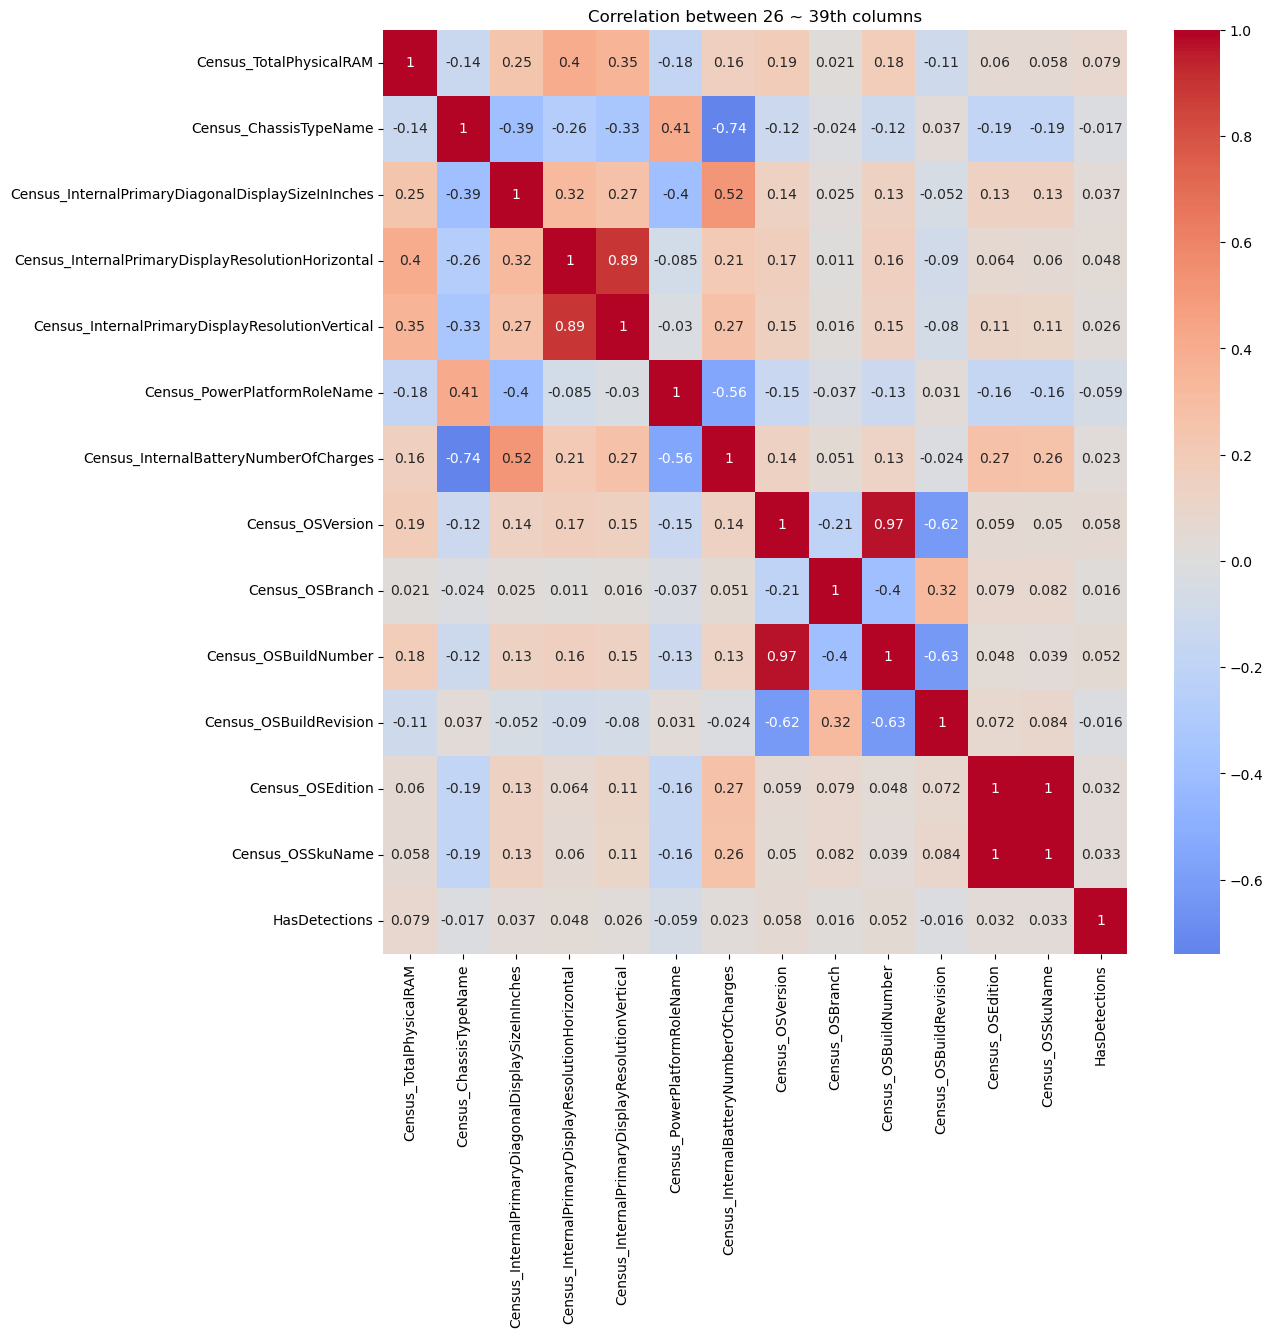

In [55]:
plt.figure(figsize=(12,12))

group_cols = cols[26:39]
group_cols.append('HasDetections')

sns.heatmap(retrain[group_cols].corr(), cmap='coolwarm', annot=True, center=0.0)

plt.title('Correlation between 26 ~ 39th columns')
plt.show()

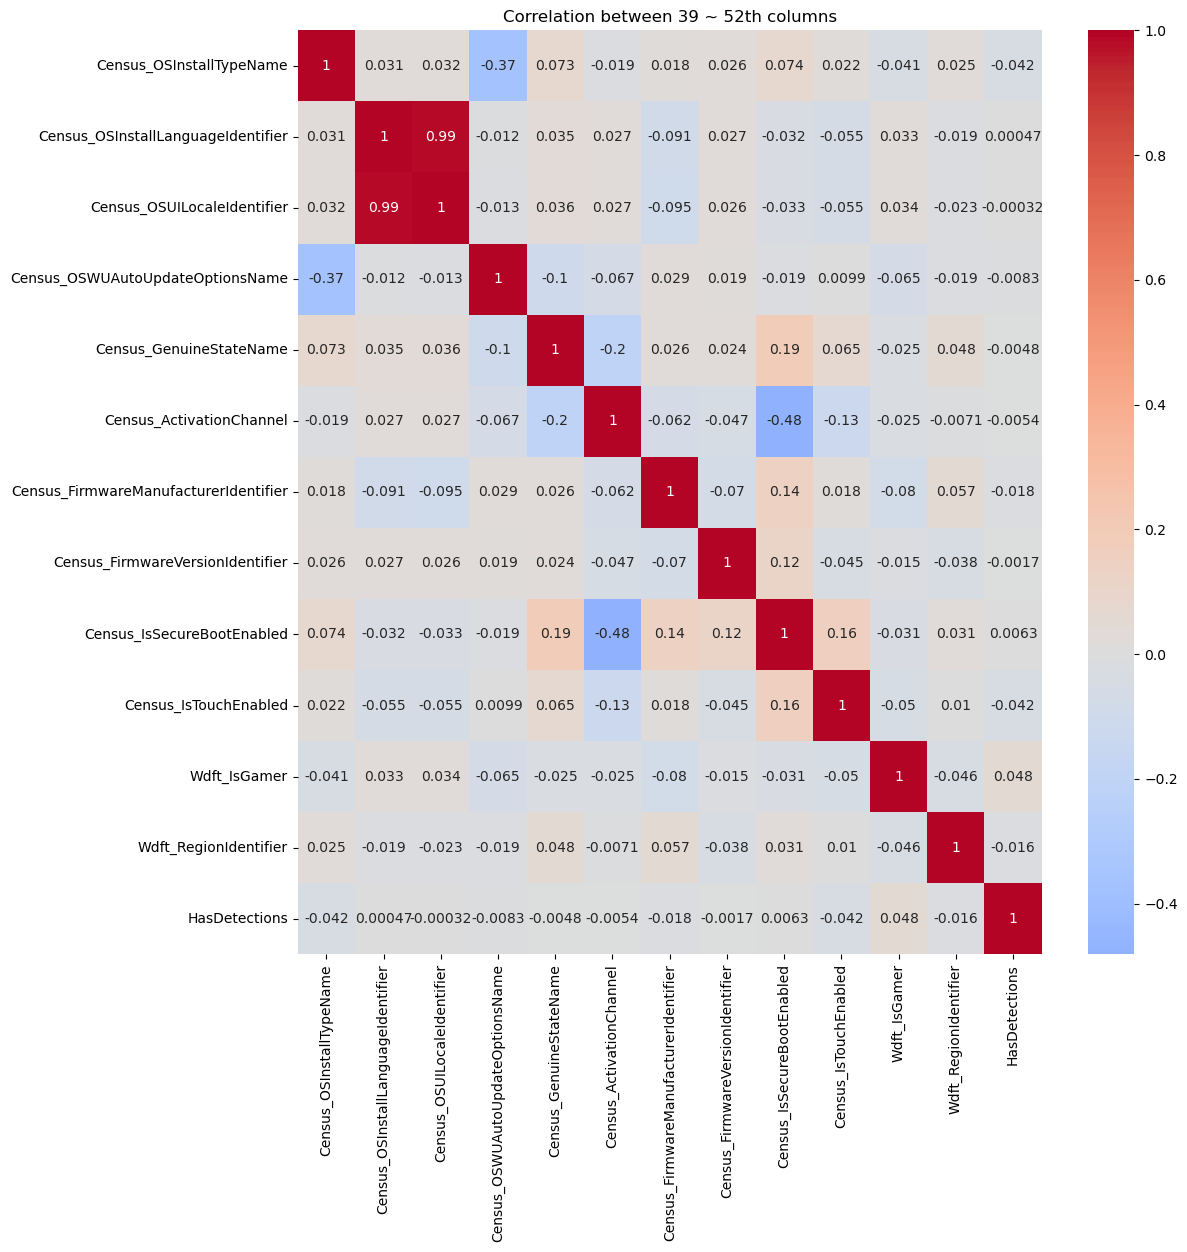

In [56]:
plt.figure(figsize=(12,12))

group_cols = cols[39:52]

sns.heatmap(retrain[group_cols].corr(), cmap='coolwarm', annot=True, center=0.0)

plt.title('Correlation between 39 ~ 52th columns')
plt.show()

### 剔除特征值较少的共线性特征

In [57]:
correlation_matrix = retrain[cols].corr().abs()

features_to_remove = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if (correlation_matrix.iloc[i, j] >= 0.9) and (correlation_matrix.columns[j] not in features_to_remove):
            
            # 找到相关性大于0.9的特征对
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            
            # 比较特征值的数量
            if retrain[colname_i].nunique() > retrain[colname_j].nunique():
                features_to_remove.add(colname_j)
            else:
                features_to_remove.add(colname_i)

retrain = retrain.drop(columns=features_to_remove)

In [58]:
Pre_train = retrain
Pre_train.describe()

,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsPlatformSubRelease,...,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,5.073302e+06,5.073302e+06,5.073302e+06,5073302.0,5.073302e+06,5.073302e+06,5073302.0,5073302.0,5.073302e+06,5.073302e+06,...,5.073302e+06,5.073302e+06,5.073302e+06,5073302.0,5.073302e+06,5.073302e+06,5.073302e+06,5073302.0,5073302.0,5.073302e+06
mean,5.074194e+01,7.670741e+03,4.680381e+04,NaN,1.076328e+02,8.088280e+04,NaN,NaN,1.243339e+02,3.463531e+00,...,1.888579e+00,9.403576e-01,1.272488e+00,NaN,3.353351e+04,5.248627e-01,1.387355e-01,NaN,NaN,5.118077e-01
std,1.831413e+01,9.041181e+02,1.522213e+04,0.0,6.275389e+01,4.872180e+04,0.0,NaN,6.974707e+01,1.426390e+00,...,1.199919e+00,2.870276e-01,1.017433e+00,NaN,2.103229e+04,4.993815e-01,3.456703e-01,0.0,0.0,4.998606e-01
min,0.000000e+00,0.000000e+00,3.000000e+00,1.0,1.000000e+00,5.000000e+00,0.0,1.0,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,11.0,1.000000e+01,0.000000e+00,0.000000e+00,0.0,1.0,0.000000e+00
25%,5.000000e+01,7.621000e+03,4.723800e+04,1.0,5.100000e+01,3.628850e+04,0.0,89.0,7.400000e+01,3.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,142.0,1.473100e+04,0.000000e+00,0.000000e+00,0.0,3.0,0.000000e+00
50%,5.600000e+01,7.875000e+03,5.344700e+04,1.0,9.700000e+01,8.237300e+04,18.0,181.0,8.800000e+01,4.000000e+00,...,2.000000e+00,1.000000e+00,2.000000e+00,500.0,3.307000e+04,1.000000e+00,0.000000e+00,0.0,10.0,1.000000e+00
75%,5.600000e+01,8.091000e+03,5.344700e+04,2.0,1.600000e+02,1.225470e+05,27.0,267.0,1.820000e+02,4.000000e+00,...,2.000000e+00,1.000000e+00,2.000000e+00,556.0,5.257000e+04,1.000000e+00,0.000000e+00,1.0,11.0,1.000000e+00
max,1.020000e+02,8.463000e+03,7.049800e+04,7.0,2.220000e+02,1.679620e+05,52.0,296.0,2.830000e+02,8.000000e+00,...,4.000000e+00,3.000000e+00,4.000000e+00,1087.0,7.210200e+04,1.000000e+00,1.000000e+00,1.0,15.0,1.000000e+00


In [60]:
file_path = r'D:\Desktop\MS ML Intern\MS Malware Pridiction\MSWeek3 - 4\pretrain.csv'
Pre_train.to_csv(file_path,index = False)

## LightGBM For Binary Classification On Stratified K-fold 

In [82]:
def extract_features_and_dtypes(df):

    # 提取特征列的名称
    features_list = df.columns.tolist()
    
    # 提取特征列的数据类型并转换为字典
    dtypes_dict = df.dtypes.apply(lambda x: x.name).to_dict()
    
    return features_list, dtypes_dict

# 调用函数并提取特征和数据类型
Pre_train_features, Pre_train_dtypes = extract_features_and_dtypes(Pre_train)

In [84]:
import csv

# 将字典保存为 CSV
with open(r'D:\Desktop\MS ML Intern\MS Malware Pridiction\MSWeek3 - 4\features.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in Pre_train_dtypes.items():
        writer.writerow([key, value])

In [74]:
#Pre_train_features4test = Pre_train_features.remove('HasDetections')
%time test = reduce_mem_usage1(pd.read_csv(r'D:\Desktop\MS ML Intern\MS Malware Pridiction\MSWeek3 - 4\test.csv', usecols=Pre_train_features))

<timed exec>:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.


Memory usage of dataframe is 4913.08 MB
Memory usage after optimization is: 1449.21 MB
Decreased by 70.5%
CPU times: total: 1min 18s
Wall time: 6min 40s


## LGBM

In [4]:
%time Pre_train = pd.read_csv(r'D:\Desktop\MS ML Intern\MS Malware Pridiction\MSWeek3 - 4\Pretrain.csv')

CPU times: total: 11.6 s
Wall time: 15.5 s


In [5]:
Pre_train = reduce_mem_usage1(Pre_train)

Memory usage of dataframe is 1703.07 MB
Memory usage after optimization is: 425.77 MB
Decreased by 75.0%


In [6]:
# 获取所有Object类型的列
%time object_columns = sample_chunk.select_dtypes(include=['object']).columns

categorical_features = [col for col in object_columns if col in Pre_train.columns]

categorical_features

CPU times: total: 0 ns
Wall time: 998 µs


['AppVersion',
 'AvSigVersion',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel']

## K-fold CV

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 分离特征和标签
X = Pre_train.drop(["HasDetections",],axis = 1)
y = Pre_train["HasDetections"]
# 训练测试分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBM 参数
params = {
        'objective': 'binary',
        'learning_rate': 0.1,
        'num_leaves': 2047,
        'max_depth': -1,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        "boosting_type": "gbdt", 
        "bagging_fraction": 0.7,
        "random_state": 1,
        "metric": ['binary', 'auc'],
}

# 创建一个分层k折交叉验证器
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

num_boost_round = 20

# 预测值存储
pred_test = np.zeros(len(X_test))

# 训练模型并预测测试集
ct = 0
for train_index, val_index in skf.split(X_train, y_train):
    ct += 1
    print('####### FOLD', ct, '#########')

    # 创建数据集
    lgb_train = lgb.Dataset(X_train.iloc[train_index], y_train.iloc[train_index], 
                            categorical_feature=categorical_features)
    
    lgb_val = lgb.Dataset(X_train.iloc[val_index], y_train.iloc[val_index], 
                          reference=lgb_train, categorical_feature=categorical_features)

    # 训练模型
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val],num_boost_round=num_boost_round)

    # 预测测试集
    pred_test += model.predict(X_test) / skf.n_splits


    # 清理内存
    gc.collect()



####### FOLD 1 #########


D:\Anaconda3\envs\pytorch\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
# 获取特征重要性
feature_imp = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# 创建特征重要性的 DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_imp})

# 绘制特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
#AUC曲线
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 不使用K-fold CV

In [8]:
# 转换数据格式
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置参数
params = {
    'objective': 'binary',
    'learning_rate': 0.06,
    'num_leaves': 2048,
    'max_depth': -1,
    'colsample_bytree': 0.5,
    'n_jobs': -1,
    "boosting_type": "gbdt",
    "bagging_fraction": 0.7,
    "random_state": 2024,
    "metric": ['binary', 'auc'],
    'n_estimators': 100
}

# 训练模型
modelLGB1 = lgb.train(params, train_data, valid_sets=[train_data, test_data])

D:\Anaconda3\envs\pytorch\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2077107, number of negative: 1981534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4333
[LightGBM] [Info] Number of data points in the train set: 4058641, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511774 -> initscore=0.047105
[LightGBM] [Info] Start training from score 0.047105


In [10]:
from sklearn.metrics import classification_report

y_pred1 = modelLGB1.predict(X_test)
y_pred1 = (y_pred1 > 0.5).astype(int)  # 将概率转换为类别标签

report1 = classification_report(y_test, y_pred1)
print(report1)


              precision    recall  f1-score   support

           0       0.67      0.70      0.68    495213
           1       0.70      0.67      0.68    519448

    accuracy                           0.68   1014661
   macro avg       0.68      0.68      0.68   1014661
weighted avg       0.68      0.68      0.68   1014661



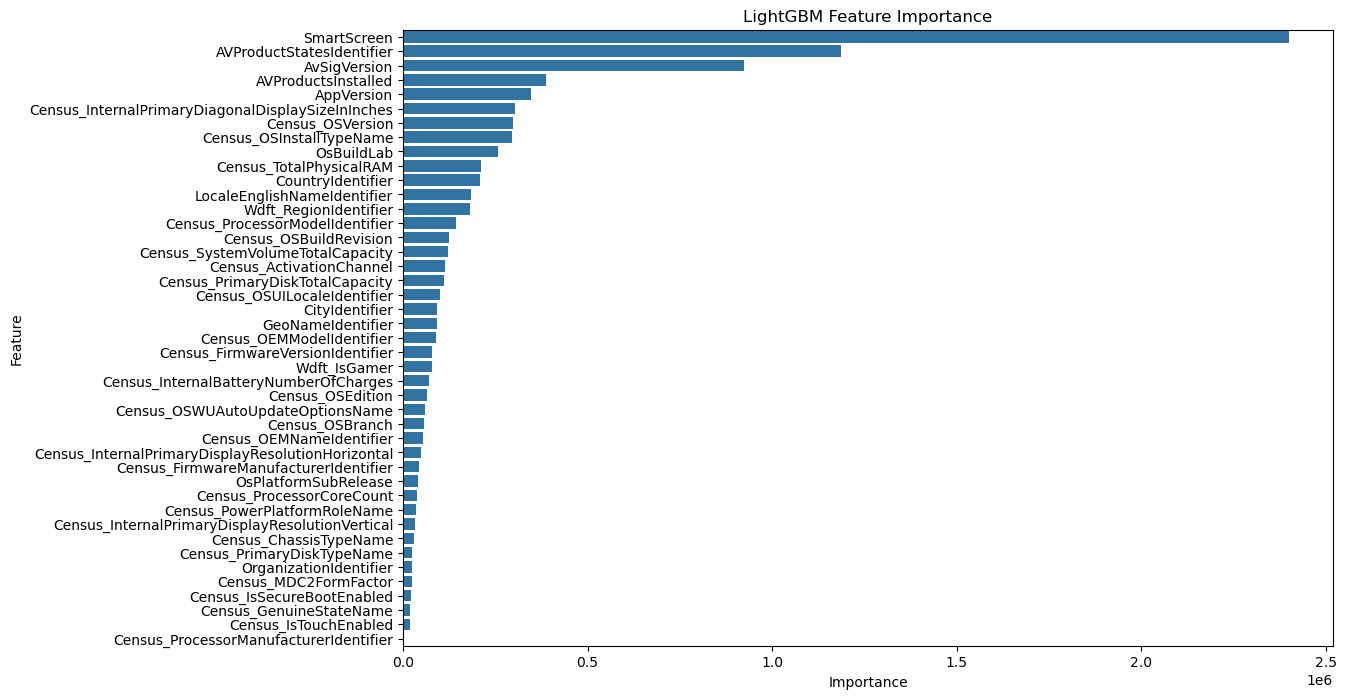

In [20]:
# 获取特征重要性
feature_importances = modelLGB1.feature_importance(importance_type='gain')

# 获取特征名称
feature_names = X_train.columns.tolist()

# 创建特征重要性的 DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 绘制特征重要性图表
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

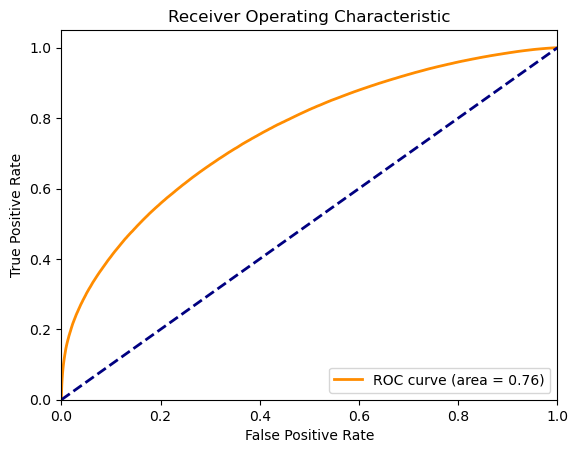

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 计算预测概率
y_pred_prob = modelLGB1.predict(X_test)

# 计算 TPR 和 FPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 计算 AUC 分数
roc_auc = auc(fpr, tpr)

# 绘制 AUC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### load Test dataset

In [23]:
features = pd.read_csv(r'D:\Desktop\MS ML Intern\MS Malware Pridiction\MSWeek3 - 4\features.csv',header = None)

In [37]:
features.columns = ['features','dtypes']

dtype_dict = dict(zip(features['features'], features['dtypes']))

usecols = features['features'].tolist()

In [38]:
usecols.append('MachineIdentifier')
usecols.remove('HasDetections')
usecols

['AppVersion',
 'AvSigVersion',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSVersion',
 'Census_OSBranch',
 'Census_OSBuildRevision',
 'Census_OSEdition',
 'Census_OSInstallTypeName',
 'Census_OSUILocaleIdentifier'

In [40]:
%time test = reduce_mem_usage1(pd.read_csv(r'D:\Desktop\MS ML Intern\MS Malware Pridiction\MSWeek3 - 4\test.csv', usecols=usecols))

Memory usage of dataframe is 2636.29 MB
Memory usage after optimization is: 1014.81 MB
Decreased by 61.5%
CPU times: total: 50.5 s
Wall time: 1min 26s


In [42]:
MachineIdentifier = test['MachineIdentifier']

In [43]:
test = test.drop(['MachineIdentifier'],axis = True)

In [44]:
category_cols = test.select_dtypes(include = 'category').columns.tolist()

from sklearn.preprocessing import LabelEncoder

# 创建 LabelEncoder 对象
le = LabelEncoder()

for col in category_cols:
    test[col] = le.fit_transform(test[col])

In [47]:
test = reduce_mem_usage1(test)

Memory usage of dataframe is 666.56 MB
Memory usage after optimization is: 666.56 MB
Decreased by 0.0%


In [50]:
y_pred_prob = modelLGB1.predict(test)

In [55]:
results_df = pd.DataFrame({
    'MachineIdentifier': MachineIdentifier,
    'PredictedProbability': y_pred_prob
})

In [58]:
results_df.columns = ['MachineIdentifier','HasDetections']

In [60]:
results_df.to_csv('prediction_results.csv', index=False)